# Predicting House Prices on Kaggle

This is the first try to use Pytorch to do the competitions on Kaggle. The house prediction is a good place to start. Since it is a clean and structured data with so many studies done already. We will try to use linear activations provided in Pytorch to complete the prediction. This notebook will focus on prediction and modeling rather than EDA. </br>
Throughout this notebook, we will demonstrate how to do data preprocessing, model design, and hyperparameter selection. </br>
authorization belongs to *d2l.ai*

## Downloading and Caching Datasets

> Here, we implement several utility functions to facilitate data downloading. First, we maintain a dictionary DATA_HUB that maps a string(the name of dataset) to a tuple containing both the URL and SHA-1 key that verifies the integrity of the file. All such datasets are hosted at the site whose address is DATA_URL

In [2]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/d2l-ai/d2l-zh (to revision release) to /tmp/pip-req-build-eaaf876q
  Running command git clone -q https://github.com/d2l-ai/d2l-zh /tmp/pip-req-build-eaaf876q
  Running command git checkout -b release --track origin/release
  Switched to a new branch 'release'
  Branch 'release' set up to track remote branch 'release' from 'origin'.
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 15.7 MB 25.8 MB/s 
     |████████████████████████████████| 11.2 MB 44.6 MB/s 
     |████████████████████████████████| 61 kB 6.6 MB/s 
     |████████████████████████████████| 9.9 MB 39.7 MB/s 
     |████████████████████████████████| 930 kB 50.7 MB/s 
  Created wheel for d2l: filename=d2l-2.0.0b0-py3-none-any.whl size=80152 sha256=bcb7a0091a8757a7b9ac3ffa79cf3fb673e08249e44c0ecc15bc2b292d49e106
  Stored in directory: /tmp/pip-ephem-wh

In [33]:
import hashlib
import os
import tarfile
import zipfile
import requests


DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

> The following download function downloads a dataset, caches it in a local directory, and returns the name of the downloaded file. If a file corresponding to this dataste already exists in the cache directory, and its SHA-1 matches the one stored in datahub, we will use the cached file to avoid redownloading.

In [34]:
def download(name,cache_dir = os.path.join('..','data')):
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname


> We also implement two additional utility functions: one is to download and extract a zip or tar file and the other to download all the datasets used in this book from DATA_HUB into the cache directory.

In [35]:
def download_extract(name, folder=None):  
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  
    """Download all files in the DATA_HUB."""
    for name in DATA_HUB:
        download(name)

## Accessing and Reading the Dataset

In [36]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [37]:
#For convenience, we can download and cache the Kaggle housing dataset using the script we defined above.
DATA_HUB['kaggle_house_train'] = (  
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [38]:
#we use pandas to load the two csv files and containing training and test data respectively
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [39]:
#The training dataset includes 1460 examples, 80 features, and 1 label, while the test data contains 1459 examples and 80 features.
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [40]:
print(train_data.iloc[:4,[0,1,2,3,-3,-2,-1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [41]:
print(test_data.iloc[:4,[0,1,2,3,-3,-2,-1]])

     Id  MSSubClass MSZoning  LotFrontage  YrSold SaleType SaleCondition
0  1461          20       RH         80.0    2010       WD        Normal
1  1462          20       RL         81.0    2010       WD        Normal
2  1463          60       RL         74.0    2010       WD        Normal
3  1464          60       RL         78.0    2010       WD        Normal


In [42]:
#remove Id since it doesn't carry any information
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:])) # here we didn't include the last column in training set because its our label

In [43]:
all_features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [44]:
all_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

## Data Preprocessing

As shown above, we have lots of different types and ranges of variables, some of them need to be preprocessed before we begin our modeling to avoid biases.  

### Data Standardization

Let's start with numerical features. First, we replace all missing values by the corresponding mean, then to pull all features on a common scale, we standardize data by rescalling the features to  zero mean and unit variance </br>

$$x \leftarrow \frac{x - \mu}{\sigma},$$ </br>
</br>
**note, we need to use the same mean and std for standardization of train and test set**

In [45]:
#filter out the numeric variables
numeric_features = all_features.dtypes[all_features.dtypes != "object"].index
#standardize
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x-x.mean())/(x.std()))

# After standardizing the data all means vanish, hence we can set missing
# values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)



In [46]:
numeric_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

### One-Hot Encoding

Next, we need to deal with characteristic features. 

In [47]:
# `Dummy_na=True` considers "na" (missing value) as a valid feature value, and
# creates an indicator feature for it
all_features = pd.get_dummies(all_features,dummy_na=True)
all_features.shape #see we have increase our number of features a lot, this might be a problem if we got a lot of features

(2919, 331)

> Till now, it's all Numpy operations. To use Pytorch in our training, we need to extract the Numpy format from the pandas format and convert it into the tensor representation for traning

In [48]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,dtype = torch.float32) #extract all training examples
test_features = torch.tensor(all_features[n_train:].values,dtype = torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1,1),dtype = torch.float32)
# reshape(-1,1) reshaped saleprice to an 2darray with 1 column, without know the number of rows

In [49]:
train_data.SalePrice.values.reshape(-1,1)

array([[208500],
       [181500],
       [223500],
       ...,
       [266500],
       [142125],
       [147500]])

## Training

To get started we train a linear model with squared loss. Not surprisingly, our linear model will not lead to a competition-winning submission but it provides a sanity check to see whether there is meaningful information in the data. If we cannot do better than random guessing here, then there might be a good chance that we have a data processing bug. And if things work, the linear model will serve as a baseline giving us some intuition about how close the simple model gets to the best reported models, giving us a sense of how much gain we should expect from fancier models.

In [50]:
loss = nn.MSELoss()
in_features= train_features.shape[1]

def get_net():
  #input size = in_features, output size = 1
  net = nn.Sequential(nn.Linear(in_features,1))
  return net

With house prices, as with stock prices,
we care about relative quantities
more than absolute quantities.
Thus [**we tend to care more about
the relative error $\frac{y - \hat{y}}{y}$**]
than about the absolute error $y - \hat{y}$.
For instance, if our prediction is off by USD 100,000
when estimating the price of a house in Rural Ohio,
where the value of a typical house is 125,000 USD,
then we are probably doing a horrible job.
On the other hand, if we err by this amount
in Los Altos Hills, California,
this might represent a stunningly accurate prediction
(there, the median house price exceeds 4 million USD).

(**One way to address this problem is to
measure the discrepancy in the logarithm of the price estimates.**)
In fact, this is also the official error measure
used by the competition to evaluate the quality of submissions.
After all, a small value $\delta$ for $|\log y - \log \hat{y}| \leq \delta$
translates into $e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$.
This leads to the following root-mean-squared-error between the logarithm of the predicted price and the logarithm of the label price:

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$

In [51]:
def log_rmse(net,features, labels):
  # To further stabilize the value when the logarithm is taken, set the
  # value less than 1 as 1
  clipped_preds = torch.clamp(net(features),1,float('inf')) #clamp all input into a range of [1,inf]
  rmse = torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels)))
  return rmse.item()



[our training functions will rely on the Adam optimizer (we will describe it in greater detail later)]. The main appeal of this optimizer is that, despite doing no better (and sometimes worse) given unlimited resources for hyperparameter optimization, people tend to find that it is significantly less sensitive to the initial learning rate.

> the train function includes the forward and backward propagation. The output would be the the loss for train and test set. And we used mini-batch in our training. </br>
So the loop would be: for each epoch, for each batch, we set our grads to zero, calculate loss, calculate grads and update parameters. Then we append log rmse for each epoch. 

In [52]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
  train_ls, test_ls = [],[]
  train_iter = d2l.load_array((train_features, train_labels),batch_size)

  optimizer = torch.optim.Adam(net.parameters(),lr = learning_rate,weight_decay=weight_decay)

  for epoch in range(num_epochs):
    for X,y in train_iter:
      optimizer.zero_grad()
      l = loss(net(X),y)
      l.backward()
      optimizer.step()
    train_ls.append(log_rmse(net, train_features, train_labels))
    if test_labels is not None:
      test_ls.append(log_rmse(net,test_features,test_labels))
      
  return train_ls, test_ls


## K-fold Cross-Validation

We will put this to good use to select the model design
and to adjust the hyperparameters.
We first need a function that returns
the $i^\mathrm{th}$ fold of the data
in a $K$-fold cross-validation procedure.
It proceeds by slicing out the $i^\mathrm{th}$ segment
as validation data and returning the rest as training data.
Note that this is not the most efficient way of handling data
and we would definitely do something much smarter
if our dataset was considerably larger.
But this added complexity might obfuscate our code unnecessarily
so we can safely omit it here owing to the simplicity of our problem.

In [53]:
def get_k_fold_data(k,i,X,y):
  assert k>1
  fold_size = X.shape[0]//k
  X_train,y_train = None, None
  for j in range(k):
    idx = slice(j*fold_size,(j+1)*fold_size)#The slice() function returns a slice object. A slice object is used to specify how to slice a sequence. 
    X_part, y_part = X[idx,:],y[idx]
    if j ==i: #if j =i means we will take this fold as our validation set
      X_valid,y_valid = X_part,y_part
    elif X_train is None: #if X_train is None, means this is the first time we loop
      X_train, y_train = X_part,y_part
    else:
      X_train = torch.cat([X_train,X_part],0) # 0 means concat rows
      y_train = torch.cat([y_train,y_part],0)
  return X_train,y_train,X_valid,y_valid


> The training and validation error averages are returned when we train K times in the K-fold cross validation

In [54]:
def k_fold(k,X_train,y_train, num_epochs, learning_rate, weight_decay, batch_size):
  train_l_sum, valid_l_sum = 0,0
  for i in range(k):
    data = get_k_fold_data(k,i,X_train, y_train)
    net = get_net()
    train_ls , valid_ls = train(net, *data, num_epochs, learning_rate,weight_decay,batch_size)
    train_l_sum +=train_ls[-1]
    valid_l_sum +=valid_ls[-1]

    if i == 0:
      d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
      print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, 'f'valid log rmse {float(valid_ls[-1]):f}')
    
  return train_l_sum/k , valid_l_sum/k
      

## Model Selection
In this example, we pick an untuned set of hyperparameters and leave it up to the reader to improve the model. Finding a good choice can take time, depending on how many variables one optimizes over. With a large enough dataset, and the normal sorts of hyperparameters,  𝐾 -fold cross-validation tends to be reasonably resilient against multiple testing. However, if we try an unreasonably large number of options we might just get lucky and find that our validation performance is no longer representative of the true error.

In [55]:
pip install matplotlib==3.0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


fold 1, train log rmse 0.170109, valid log rmse 0.156688
5-fold validation: avg train log rmse: 0.165445, avg valid log rmse: 0.170000


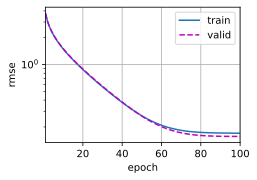

In [56]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k,train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

## Making Predictions


In [57]:
def train_and_pred(train_features, test_features, train_labels,test_data, num_epochs,lr, weight_decay,batch_size):
  net = get_net()
  train_ls,_ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
  d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
  print(f'train log rmse {float(train_ls[-1]):f}')

  #apply the network to the test set
  preds = net(test_features).detach().numpy()
  #reformat for export
  test_data['SalePrice'] = pd.Series(preds.reshape(1,-1)[0])
  submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
  submission.to_csv('submission.csv', index=False)



>One nice sanity check is to see
whether the predictions on the test set
resemble those of the $K$-fold cross-validation process.

train log rmse 0.162835


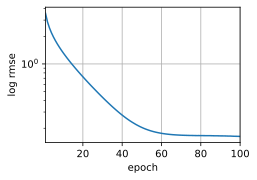

In [58]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)